In [147]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [148]:
columns_to_read =  ["Omega", "Beta", "Delta", "F1", "F2"]
generated_data = pd.read_csv("Generated_Data.csv", names=columns_to_read)

In [149]:
generated_data.sample(5)

,Omega,Beta,Delta,F1,F2
54635,-0.142857,0.714286,0.042857,-0.157439,0.707021
17274,-0.755102,0.836735,-0.002041,-0.769819,0.829414
11588,-0.836735,0.265306,0.055102,-0.768291,0.280742
111080,0.795918,-0.142857,0.022449,0.702618,-0.165119
20195,-0.673469,-0.877551,0.083673,-0.656003,-0.869500


In [150]:
generated_data = generated_data.values

In [151]:
X = generated_data[:, :3]  # Input features (first 3 columns)
y = generated_data[:, 3:]  # Output (F1 and F2)


In [152]:
# splitting the training and the test datasets 90 to 10 %
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [153]:
def plot_comp_original_model(net, test):
    # test neural network
    n_sample = 50
    x_ax = [i for i in range(n_sample)]

    inputs = torch.tensor(X_test[:n_sample], dtype=torch.float32)
    y_pred_tensor = net(inputs)
    y_pred =  y_pred_tensor.detach().cpu().numpy()
    y_act = y_test[:n_sample]

    # Create a scatter plot for F1 and F2 using the combined values
    plt.figure(figsize=(12, 6))

    # Plot F1
    plt.subplot(1, 2, 1)
    plt.plot(x_ax, y_pred[:, 0], label='F1 (Ground Truth)')
    plt.plot(x_ax, y_act[:, 0], label='F1 (NN Prediction)')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Comparison of Ground Truth and NN Predictions (F1)')
    plt.legend()
    plt.grid(True)

    # Plot F2
    plt.subplot(1, 2, 2)
    plt.plot(x_ax, y_pred[:, 1], label='F2 (Ground Truth)')
    plt.plot(x_ax, y_act[:, 1], label='F2 (NN Prediction)')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Comparison of Ground Truth and NN Predictions (F2)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
def plot_loss(num_epochs, losses, opt_name):
    # Plot the epoch vs. loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Epoch vs. Loss '+opt_name) 
    plt.legend()
    plt.grid(True)
    plt.show()

In [154]:
learning_rate = 0.001
momentum = 0.8
num_epochs = 1000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 64)  # 3 input features, 64 hidden units
        self.fc2 = nn.Linear(64, 64)  # 64 hidden units, 64 hidden units
        self.fc3 = nn.Linear(64, 2)  # 64 hidden units, 2 output units for F1 and F2

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# set training and params
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizers = ["SGD", "nesterov-SGD", "Adagrad", "RMSprop", "Adam"]

train_loss = []
test_loss = []

In [155]:
def train(net, num_epochs, X_train, y_train, optimizer, criterion):
    losses = []
    for epoch in tqdm(range(num_epochs), unit="epoch"):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())  # Collect the loss value

        if (epoch + 1) % 100 == 0:
            tqdm.write(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    return net, losses

def test(net, X_test, y_test):
    net = net.eval()
    inputs = torch.tensor(X_test, dtype=torch.float32)
    targets = torch.tensor(y_test, dtype=torch.float32)
    
    with torch.no_grad():
        predicted_forces = net(inputs)
    
    loss = criterion(predicted_forces, targets)
    return loss.item()

## SGD

 10%|█         | 100/1000 [00:39<06:11,  2.42epoch/s]

Epoch [100/1000], Loss: 0.3352


 20%|██        | 200/1000 [01:20<04:50,  2.75epoch/s]

Epoch [200/1000], Loss: 0.3167


 30%|███       | 300/1000 [02:00<05:13,  2.23epoch/s]

Epoch [300/1000], Loss: 0.3000


 40%|████      | 400/1000 [02:41<03:35,  2.79epoch/s]

Epoch [400/1000], Loss: 0.2845


 50%|█████     | 500/1000 [03:21<04:09,  2.00epoch/s]

Epoch [500/1000], Loss: 0.2698


 60%|██████    | 600/1000 [04:02<02:27,  2.71epoch/s]

Epoch [600/1000], Loss: 0.2558


 70%|███████   | 700/1000 [04:43<02:16,  2.21epoch/s]

Epoch [700/1000], Loss: 0.2422


 80%|████████  | 800/1000 [05:23<01:15,  2.64epoch/s]

Epoch [800/1000], Loss: 0.2289


 90%|█████████ | 900/1000 [06:04<00:47,  2.12epoch/s]

Epoch [900/1000], Loss: 0.2158


100%|██████████| 1000/1000 [06:45<00:00,  2.47epoch/s]


Epoch [1000/1000], Loss: 0.2031
Training loss:  0.2031465321779251
Testing loss:  0.20488174259662628


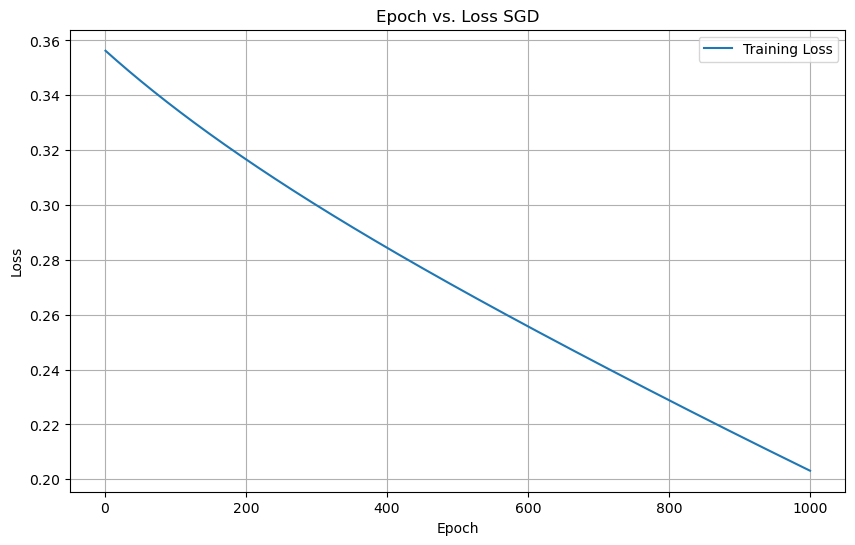

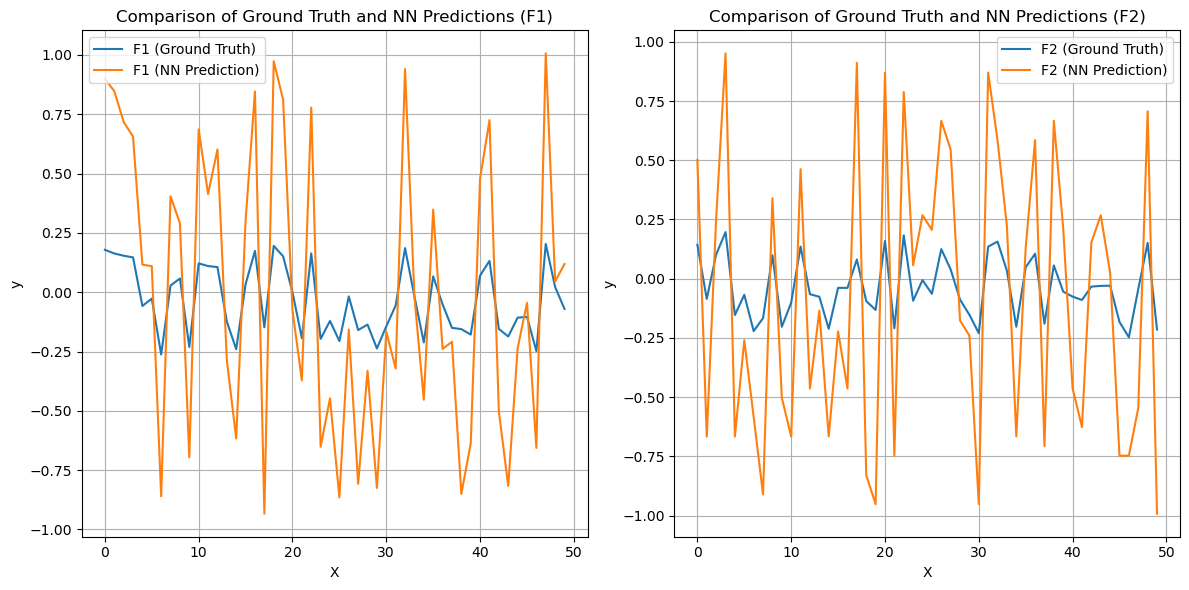

In [156]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
net, losses = train(net, num_epochs, X_train, y_train, optimizer, criterion)

train_loss.append(losses[-1])
test_loss.append(test(net, X_test, y_test))

print('Training loss: ',train_loss[-1])
print('Testing loss: ', test_loss[-1])

plot_loss(num_epochs, losses,  "SGD")
plot_comp_original_model(net, X_test)

Comments on SGD algorithm: The continued decline in loss indicates that the model is still learning and improving its performance. This could mean that the model has not yet fully converged to its optimal state, and training for more epochs could lead to further improvements, albeit at a slower rate.

## nesterov-SGD

 10%|█         | 100/1000 [00:41<05:42,  2.63epoch/s]

Epoch [100/1000], Loss: 0.2790


 20%|██        | 200/1000 [01:24<06:38,  2.01epoch/s]

Epoch [200/1000], Loss: 0.2144


 30%|███       | 300/1000 [02:04<04:24,  2.64epoch/s]

Epoch [300/1000], Loss: 0.1543


 40%|████      | 400/1000 [02:46<04:25,  2.26epoch/s]

Epoch [400/1000], Loss: 0.1018


 50%|█████     | 500/1000 [03:25<03:04,  2.71epoch/s]

Epoch [500/1000], Loss: 0.0617


 60%|██████    | 600/1000 [04:08<02:35,  2.57epoch/s]

Epoch [600/1000], Loss: 0.0354


 70%|███████   | 700/1000 [04:50<02:24,  2.08epoch/s]

Epoch [700/1000], Loss: 0.0203


 80%|████████  | 800/1000 [05:32<01:18,  2.54epoch/s]

Epoch [800/1000], Loss: 0.0125


 90%|█████████ | 900/1000 [06:15<00:42,  2.35epoch/s]

Epoch [900/1000], Loss: 0.0087


100%|██████████| 1000/1000 [06:57<00:00,  2.39epoch/s]


Epoch [1000/1000], Loss: 0.0069
Training loss:  0.0069009349681437016
Testing loss:  0.006939209997653961


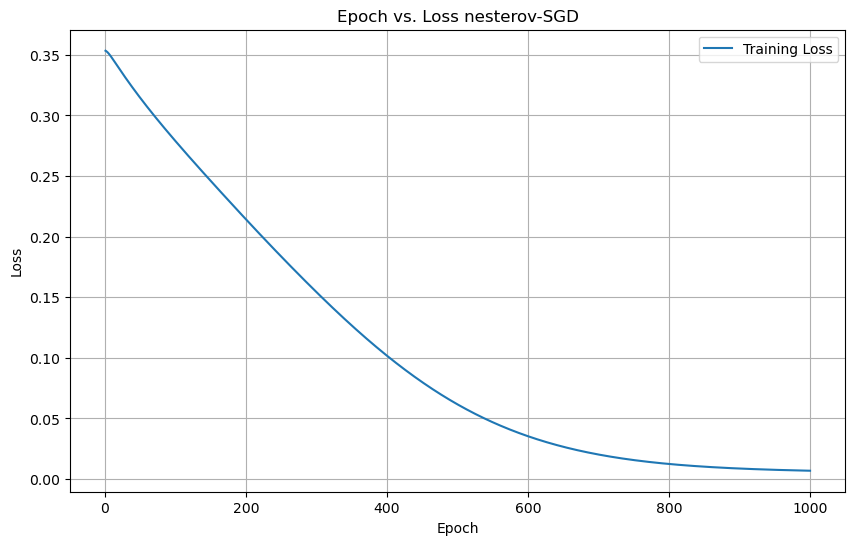

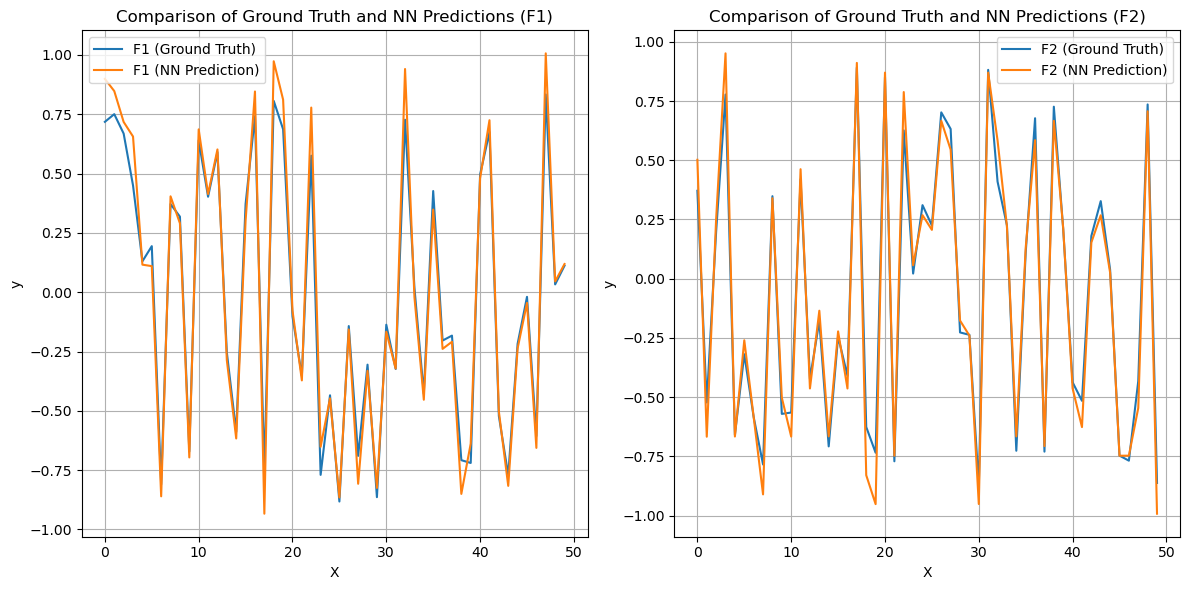

In [157]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, nesterov=True)
net, losses = train(net, num_epochs, X_train, y_train, optimizer, criterion)

train_loss.append(losses[-1])
test_loss.append(test(net, X_test, y_test))

print('Training loss: ',train_loss[-1])
print('Testing loss: ', test_loss[-1])

plot_loss(num_epochs, losses, "nesterov-SGD")
plot_comp_original_model(net, X_test)

Commnents on Nestrov SGD: The declining loss suggests that the training process is still converging, even after 1000 epochs. This is a positive sign, as it means your model continues to improve its performance on the training data.

## Adagrad

 10%|█         | 100/1000 [00:41<05:29,  2.73epoch/s]

Epoch [100/1000], Loss: 0.1096


 20%|██        | 200/1000 [01:22<05:32,  2.41epoch/s]

Epoch [200/1000], Loss: 0.0462


 30%|███       | 300/1000 [02:01<04:10,  2.79epoch/s]

Epoch [300/1000], Loss: 0.0189


 40%|████      | 400/1000 [02:41<04:33,  2.19epoch/s]

Epoch [400/1000], Loss: 0.0080


 50%|█████     | 500/1000 [03:21<03:14,  2.57epoch/s]

Epoch [500/1000], Loss: 0.0039


 60%|██████    | 600/1000 [04:04<02:43,  2.45epoch/s]

Epoch [600/1000], Loss: 0.0024


 70%|███████   | 700/1000 [04:45<02:16,  2.20epoch/s]

Epoch [700/1000], Loss: 0.0018


 80%|████████  | 800/1000 [05:26<01:13,  2.73epoch/s]

Epoch [800/1000], Loss: 0.0015


 90%|█████████ | 900/1000 [06:08<00:48,  2.07epoch/s]

Epoch [900/1000], Loss: 0.0013


100%|██████████| 1000/1000 [06:48<00:00,  2.45epoch/s]


Epoch [1000/1000], Loss: 0.0012
Training loss:  0.0011595680844038725
Testing loss:  0.001186904264613986


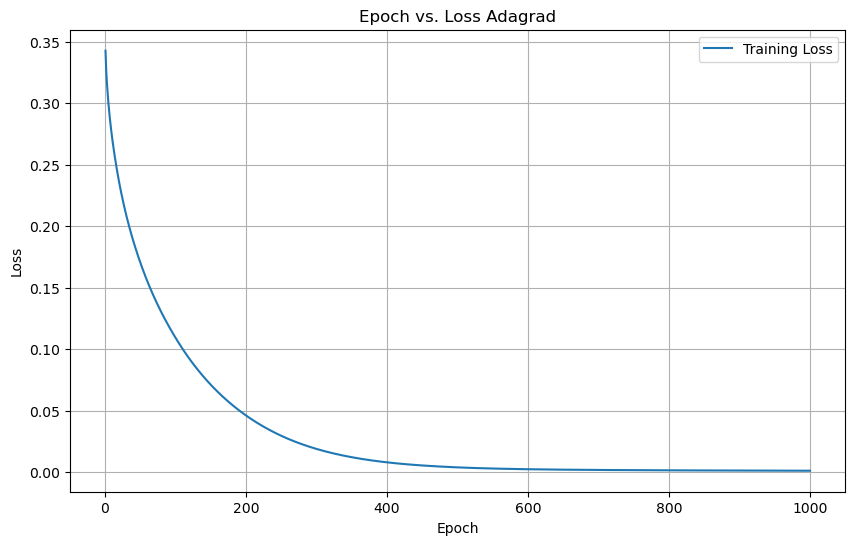

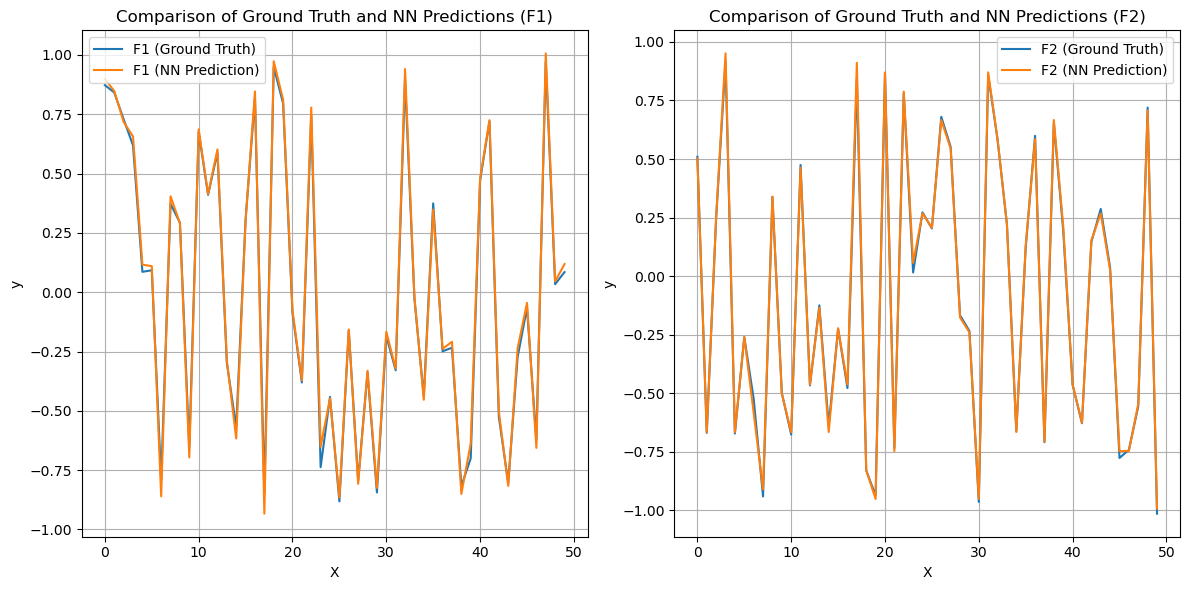

In [158]:
net = Net()
optimizer = optim.Adagrad(net.parameters(), lr=learning_rate)
net, losses = train(net, num_epochs, X_train, y_train, optimizer, criterion)

train_loss.append(losses[-1])
test_loss.append(test(net, X_test, y_test))

print('Training loss: ',train_loss[-1])
print('Testing loss: ', test_loss[-1])

plot_loss(num_epochs, losses, "Adagrad")
plot_comp_original_model(net, X_test)

Commnents on Adegard: The declining loss converged to almost zero after 600 Iterations and we can observe the NN prediction is almost the same as the Ground Truth

## RMSprop

 10%|█         | 100/1000 [00:42<06:15,  2.39epoch/s]

Epoch [100/1000], Loss: 0.0013


 20%|██        | 200/1000 [01:23<06:04,  2.20epoch/s]

Epoch [200/1000], Loss: 0.0004


 30%|███       | 300/1000 [02:05<04:33,  2.56epoch/s]

Epoch [300/1000], Loss: 0.0009


 40%|████      | 400/1000 [02:48<04:16,  2.34epoch/s]

Epoch [400/1000], Loss: 0.0004


 50%|█████     | 500/1000 [03:29<03:05,  2.70epoch/s]

Epoch [500/1000], Loss: 0.0014


 60%|██████    | 600/1000 [04:11<02:32,  2.62epoch/s]

Epoch [600/1000], Loss: 0.0007


 70%|███████   | 700/1000 [04:54<02:29,  2.01epoch/s]

Epoch [700/1000], Loss: 0.0004


 80%|████████  | 800/1000 [05:35<01:11,  2.80epoch/s]

Epoch [800/1000], Loss: 0.0005


 90%|█████████ | 900/1000 [06:19<00:37,  2.64epoch/s]

Epoch [900/1000], Loss: 0.0009


100%|██████████| 1000/1000 [07:01<00:00,  2.37epoch/s]


Epoch [1000/1000], Loss: 0.0005
Training loss:  0.0004770473169628531
Testing loss:  0.00047311719390563667


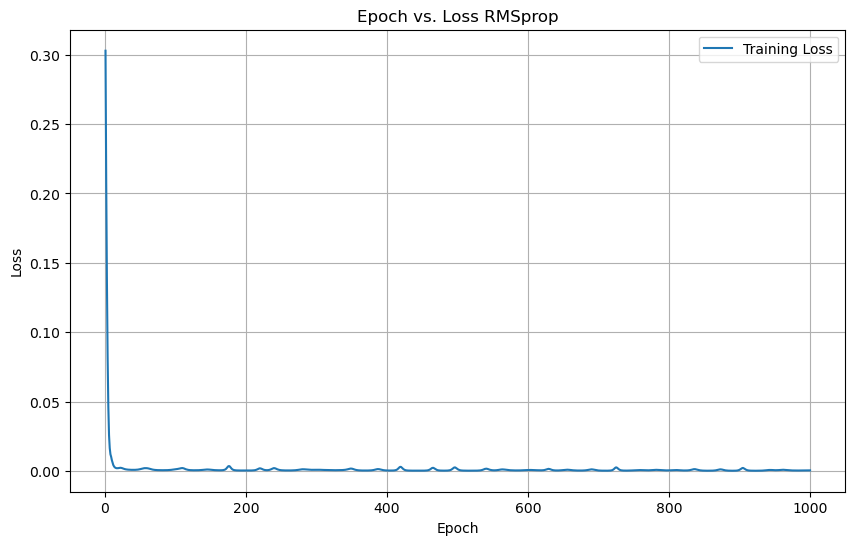

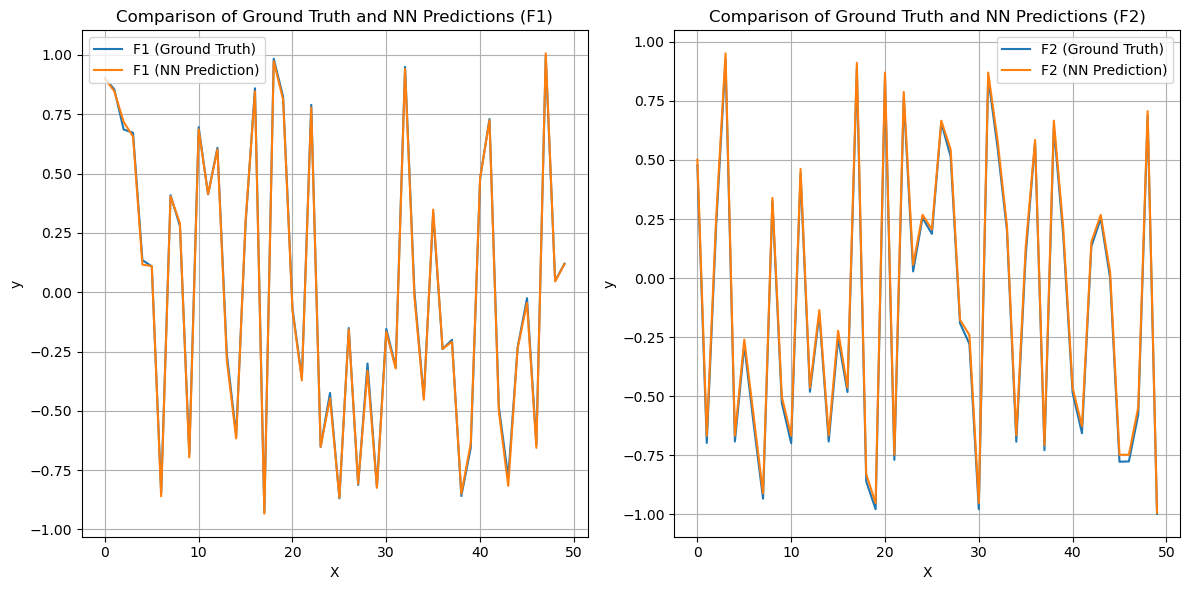

In [159]:
net = Net()
optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)
net, losses = train(net, num_epochs, X_train, y_train, optimizer, criterion)
    
train_loss.append(losses[-1])
test_loss.append(test(net, X_test, y_test))

print('Training loss: ',train_loss[-1])
print('Testing loss: ', test_loss[-1])

plot_loss(num_epochs, losses, "RMSprop")
plot_comp_original_model(net, X_test)

Commnents on RMSprop: The rapid decline in loss can after a few number of iterations. However it can be observered are minor fluctuations in the loss after reaching a stable state.

##  Adam

 10%|█         | 100/1000 [00:40<05:27,  2.75epoch/s]

Epoch [100/1000], Loss: 0.0008


 20%|██        | 200/1000 [01:24<05:25,  2.46epoch/s]

Epoch [200/1000], Loss: 0.0005


 30%|███       | 300/1000 [02:05<05:18,  2.20epoch/s]

Epoch [300/1000], Loss: 0.0004


 40%|████      | 400/1000 [02:47<03:52,  2.58epoch/s]

Epoch [400/1000], Loss: 0.0004


 50%|█████     | 500/1000 [03:29<03:15,  2.56epoch/s]

Epoch [500/1000], Loss: 0.0003


 60%|██████    | 600/1000 [04:11<03:08,  2.12epoch/s]

Epoch [600/1000], Loss: 0.0003


 70%|███████   | 700/1000 [04:52<01:57,  2.56epoch/s]

Epoch [700/1000], Loss: 0.0003


 80%|████████  | 800/1000 [05:35<01:39,  2.01epoch/s]

Epoch [800/1000], Loss: 0.0002


 90%|█████████ | 900/1000 [06:15<00:37,  2.63epoch/s]

Epoch [900/1000], Loss: 0.0002


100%|██████████| 1000/1000 [06:57<00:00,  2.39epoch/s]


Epoch [1000/1000], Loss: 0.0002
Training loss:  0.00015903259918559343
Testing loss:  0.00016064134251791984


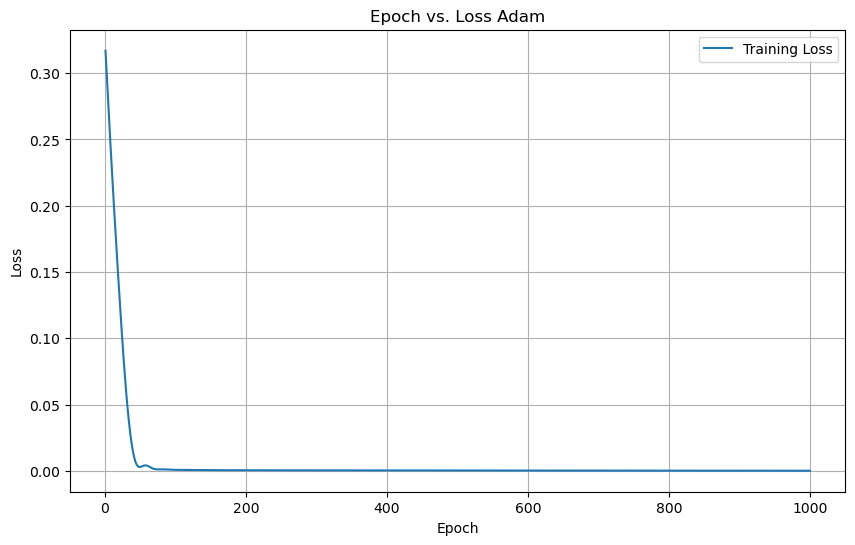

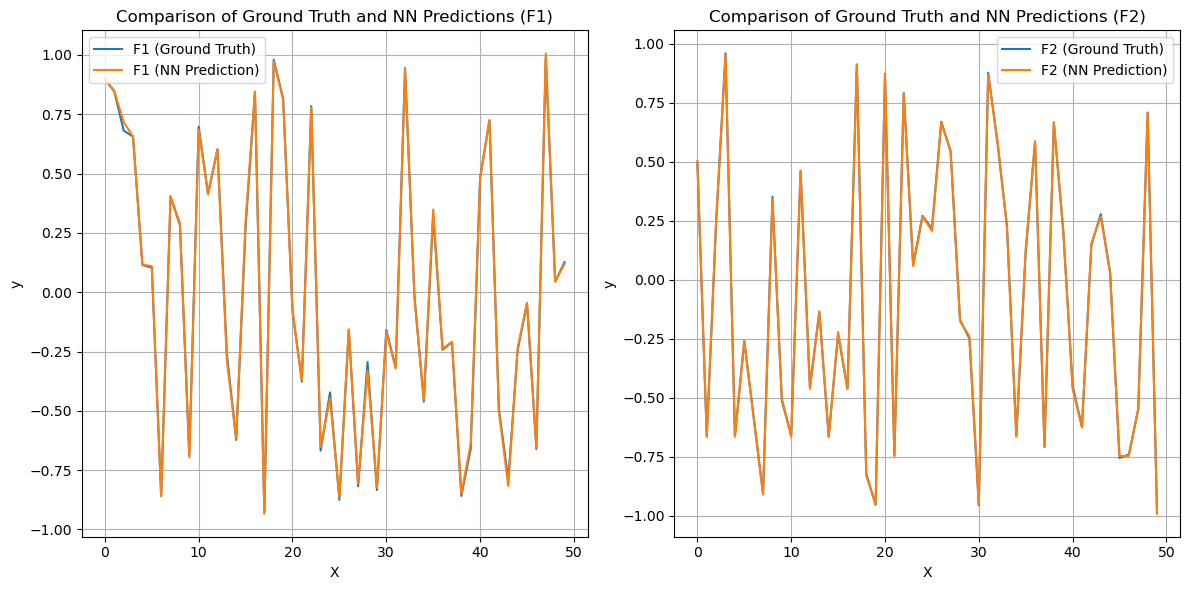

In [160]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net, losses = train(net, num_epochs, X_train, y_train, optimizer, criterion)
    
train_loss.append(losses[-1])
test_loss.append(test(net, X_test, y_test))

print('Training loss: ',train_loss[-1])
print('Testing loss: ', test_loss[-1])

plot_loss(num_epochs, losses, "Adam" )
plot_comp_original_model(net, X_test)

Commnents on Adam: The loss converged to a minumum after almost 100 iterations and the NN prediction is very similar to the Ground Truth. 

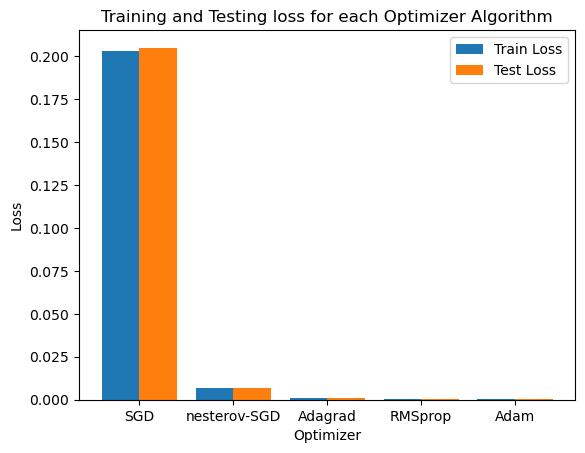

In [161]:
X_axis = np.arange(len(optimizers))
  
plt.bar(X_axis - 0.2, train_loss, 0.4, label = 'Train Loss')
plt.bar(X_axis + 0.2, test_loss, 0.4, label = 'Test Loss')
  
plt.xticks(X_axis, optimizers)
plt.xlabel("Optimizer")
plt.ylabel("Loss")
plt.title("Training and Testing loss for each Optimizer Algorithm")
plt.legend()
plt.show()

We can see from the figure above that the SGD has the highest loss which makes it the worst in this case, whereas Adegard, RMSprop and Adam were the best algorithms as they have the lowest loss. 